In [8]:
import essentia.standard as ess
import librosa as lib
import numpy as np
import matplotlib.pyplot as plt
import HTKPython as HTK
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import MultipleLocator
from matplotlib.colors import LogNorm
from essentia import Pool
from scipy import pi

In [9]:
########### extract filterbank with htk
URImfcFile = 'HTK/vignesh.mfc_no_preemph'

HTKFeat_reader =  HTK.htk_open(URImfcFile, 'rb')
htkMFCC = HTKFeat_reader.getall()
htkMFCC = htkMFCC.T
htkMFCC =htkMFCC[[-1,0,1,2,3,4,5,6,7,8,9,10,11],:]
URImfcFile = 'HTK/vignesh.fbank_no_preemf'
HTKFeat_reader =  HTK.htk_open(URImfcFile, 'rb')
htkMelBands = HTKFeat_reader.getall()

In [10]:
# configure essentia algorythms
bands = 26
coefficients = 13
liftering = 22
dctEssentia = ess.DCT(inputSize = bands,
                       outputSize=coefficients, 
                       dctType = 3, 
                       liftering = liftering)                    

pool = Pool()

Here I compute MFCC fromt he HTK melBands in Essentia. As you can see bolow the results are very different. 
In order to try to understand this I also computed MFCC from Librosa and then I manually added the liftering as in  Dan Ellis matlab implementation in order to check if there was a problem in my DCT implementation, but the result is similar to the ones with Essentia.

In [18]:
pool.clear()

#essentia computing
for melBands in htkMelBands: 
    pool.add('DCT', dctEssentia(np.log(melBands)))

essentiaMFCC = np.array(pool['DCT'].T);  

#librosa computing
librosaMFCC = lib.feature.mfcc(y=None, sr=44100, S=np.log(htkMelBands.T), n_mfcc=coefficients)


# liftering added manually to librosa
for i in range(len(librosaMFCC.T)):
    librosaMFCC[:,i] = ( 1 + 0.5*liftering*np.sin(pi*(np.arange(coefficients))/liftering) ) * librosaMFCC[:,i]



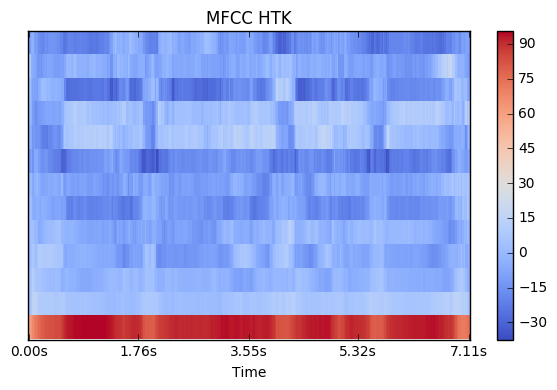

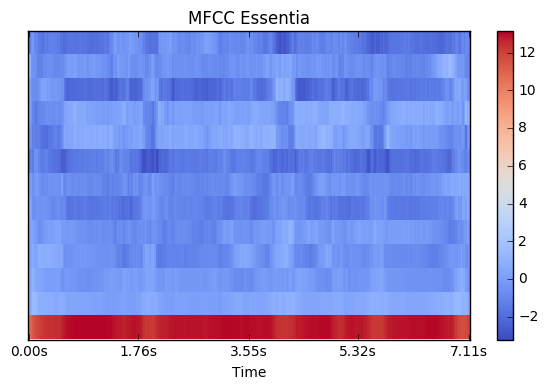

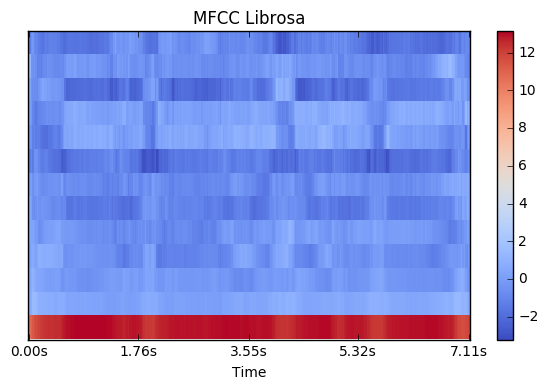

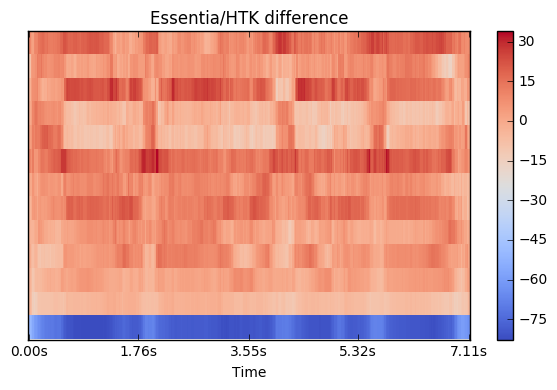

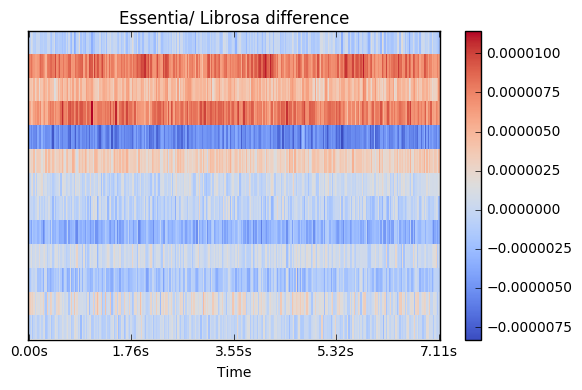

In [19]:

# Ploting HTK
lib.display.specshow(htkMFCC, x_axis='time')
plt.colorbar()
plt.title('MFCC HTK')
plt.tight_layout()
plt.show()

# Ploting Essentia
lib.display.specshow(essentiaMFCC, x_axis='time')
plt.colorbar()
plt.title('MFCC Essentia')
plt.tight_layout()
plt.show()

# Ploting Librosa
lib.display.specshow(librosaMFCC, x_axis='time')
plt.colorbar()
plt.title('MFCC Librosa')
plt.tight_layout()
plt.show()

# Ploting Essentia / HTK difference
lib.display.specshow(essentiaMFCC- htkMFCC, x_axis='time')
plt.colorbar()
plt.title('Essentia/HTK difference')
plt.tight_layout()
plt.show()

# Ploting Essentia / Librosa difference
lib.display.specshow(essentiaMFCC- librosaMFCC, x_axis='time')
plt.colorbar()
plt.title('Essentia/ Librosa difference')
plt.tight_layout()
plt.show()

Here there is some experimentation traying to understand if there is any difference in the way Librosa and HTK  computes the DCT. I try to compute the DCT III following the HTK book formula literally (As found in Robust AudioProcessor) instead of the Librosa way and I got different results but I can't understand why. However this suggests that probably we can't asume that librosa DCT III is the same as HTK. 

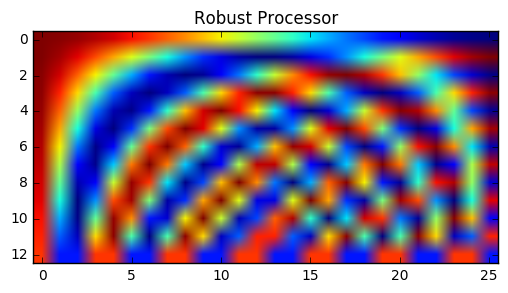

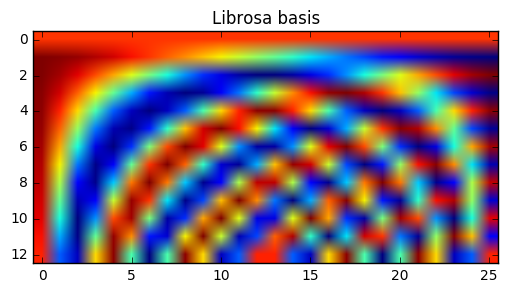

In [6]:
# dct bassis HTK formula
basis1 = np.ones((coefficients, bands))

for i in range(0, coefficients):
    for j in range (0, bands):
        basis1[i, j] = np.sqrt(2.0/bands) * np.cos((pi/bands)*(i+1)* (j+0.5)) 

plt.imshow(basis1)
plt.title('Robust Processor')
plt.show()

basis = np.empty((coefficients, bands))
basis[0, :] = 1.0 / np.sqrt(bands)

samples = np.arange(1, 2*bands, 2) * np.pi / (2.0 * bands)

for i in range(1, coefficients):
    basis[i, :] = np.cos(i*samples) * np.sqrt(2.0/bands)

plt.imshow(basis)
plt.title('Librosa basis')
plt.show()

(13, 307)


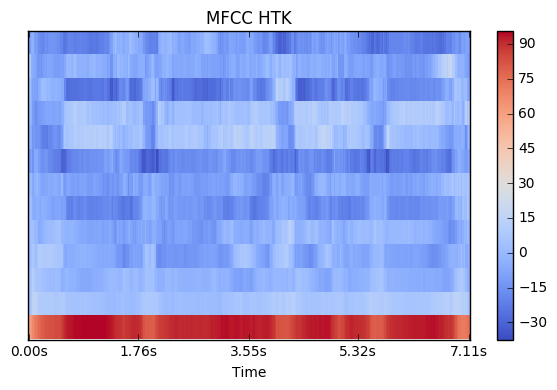

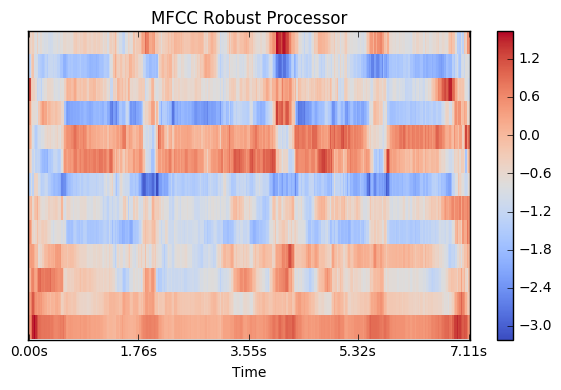

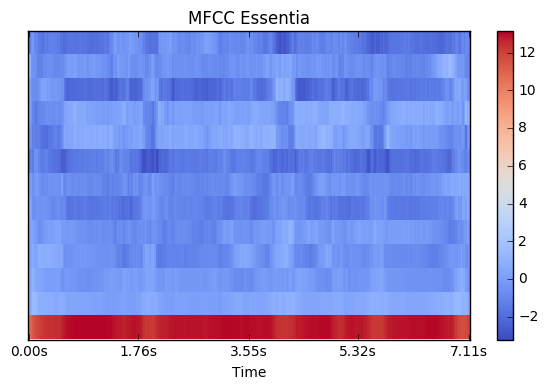

In [20]:
librosaMFCC =np.dot(basis1, np.log(htkMelBands.T))

print librosaMFCC.shape
# liftering added manually to librosa
for i in range(len(librosaMFCC.T)):
    librosaMFCC[:,i] = ( 1 + 0.5*liftering*np.sin(pi*(np.arange(coefficients)+1)/liftering) ) * librosaMFCC[:,i]

# Ploting HTK
lib.display.specshow(htkMFCC, x_axis='time')
plt.colorbar()
plt.title('MFCC HTK')
plt.tight_layout()
plt.show()
    
# Librosa
lib.display.specshow(librosaMFCC, x_axis='time')
plt.colorbar()
plt.title('MFCC Robust Processor')
plt.tight_layout()
plt.show()

# Ploting Essentia
lib.display.specshow(essentiaMFCC, x_axis='time')
plt.colorbar()
plt.title('MFCC Essentia')
plt.tight_layout()
plt.show()
